# Simple SNN by Brian2
シンプルにしたDiehl&Cookモデル(WTAネットワーク＋STDP)を用いた教師なし学習③

シナプス重みに領域制限を設けた

変数thetaでホメオスタシスも導入

In [1]:
import brian2 as b2
import numpy as np
from sklearn import datasets
np.random.seed(1)

In [2]:
# Load MNIST
mnist_X, mnist_y = datasets.fetch_openml('mnist_784', version=1, data_home="./mnist/", return_X_y=True)
x_all = mnist_X.astype(np.float32) / 255
y_all = mnist_y.astype(np.int32)
print(x_all.shape)
print(y_all.shape)

(70000, 784)
(70000,)


In [3]:
# parameter
num_examples = 100
n_input = x_all.shape[1]
n = n_e = n_i = 100
single_example_time =   0.35 * b2.second
resting_time = 0.15 * b2.second
runtime = num_examples * (single_example_time + resting_time)
input_intensity = 100 * b2.Hz # inputにおける最大のスパイク頻度

In [4]:
# Create Network
## Input layer
input_groups = {}
input_groups['X'] = b2.PoissonGroup(n_input, 0*b2.Hz)

## Excitory and Inhibitory Layer
neuron_groups = {}
v0 = -50 * b2.mV #静止膜電位
v_th = -40 * b2.mV #閾値電位
v_re = -60 * b2.mV #リセット電位
tau = 10 * b2.ms #膜時定数
ref = 2 * b2.ms # 不応期
E_ex = 0 * b2.mV # 興奮シナプスの平衡電位
E_In = -100 * b2.mV # 抑制シナプスの平衡電位

eqs = '''
dv/dt = (v0-v+(I_synE+I_synI)/nS)/tau : volt (unless refractory)
I_synE = ge * nS * (E_ex -v) : amp
I_synI = gi * nS * (E_In - v) : amp
dge/dt = -ge/(1.0*ms) : 1
dgi/dt = -gi/(2.0*ms) : 1
'''
### ホメオスタシス
tc_theta = 1e4 * b2.ms
theta_plus = 0.05 * b2.mV
offset = 10.0 * b2.mV
reset_hom = 'v = v_re; theta += theta_plus'
thresh_hom = 'v > (theta - offset + v_th)'
eqs_hom = '''
          \n dtheta/dt = -theta / (tc_theta)  : volt
          '''

neuron_groups['e'] = b2.NeuronGroup(n_e, eqs+eqs_hom, threshold=thresh_hom, reset=reset_hom, refractory=ref, method='euler')
neuron_groups['i'] = b2.NeuronGroup(n_i, eqs, threshold='v > v_th', reset='v = v_re', refractory=ref, method='euler')
neuron_groups['e'].v = neuron_groups['i'].v = -70 * b2.mV

## Synapses
w_max = 1. # 最大のシナプス荷重 
connections = {}
### STDP
tc_pre_ee = tc_post_ee = 20*b2.ms
nu_ee_pre = nu_ee_post = 0.001 # learning rate
model = '''
        w : 1
        dpre/dt   = -pre/(tc_pre_ee)       : 1 (event-driven)
        dpost/dt  = -post/(tc_post_ee)     : 1 (event-driven)
        '''
pre = '''
      pre = 1.
      w = clip(w - nu_ee_pre * post, 0, w_max)
      ge_post += w
      '''
post = '''
       post = 1.
       w = clip(w + nu_ee_post * pre, 0, w_max)
       '''
weightMatrix = w_max*np.random.rand(n_input, n_e) # 最初のweight
connections['Xe'] = b2.Synapses(input_groups['X'], neuron_groups['e'], model=model, on_pre=pre, on_post=post)
connections['Xe'].connect(True)
connections['Xe'].w = weightMatrix.reshape([-1])

### Stable connecton
ei_w = 1.
weightMatrix = ei_w * np.eye(n)
connections['ei'] = b2.Synapses(neuron_groups['e'], neuron_groups['i'], model= 'w : 1', on_pre='ge_post += w')
connections['ei'].connect(True)
connections['ei'].w = weightMatrix.reshape([-1])
ie_w = 1. / n_i
weightMatrix = ie_w * (np.ones(n) - np.eye(n))
connections['ie'] = b2.Synapses(neuron_groups['i'], neuron_groups['e'], model='w : 1', on_pre='gi_post += w')
connections['ie'].connect(True)
connections['ie'].w = weightMatrix.reshape([-1])

## Monitors
rate_monitors = {}
rate_monitors['X'] = b2.PopulationRateMonitor(input_groups['X'])
rate_monitors['e'] = b2.PopulationRateMonitor(neuron_groups['e'])
rate_monitors['i'] = b2.PopulationRateMonitor(neuron_groups['i'])
spike_counters = {}
spike_counters['e'] = b2.SpikeMonitor(neuron_groups['e'])
spike_monitors = {}
spike_monitors['X'] = b2.SpikeMonitor(input_groups['X'])
spike_monitors['e'] = b2.SpikeMonitor(neuron_groups['e'])
spike_monitors['i'] = b2.SpikeMonitor(neuron_groups['i'])
## NetWork
net = b2.Network()
for obj_list in [neuron_groups, input_groups, connections, rate_monitors, spike_monitors, spike_counters]:
    for key in obj_list:
        net.add(obj_list[key])

In [5]:
# Networkの設定確認
net.scheduling_summary()

object,part of,Clock dt,when,order,active
neurongroup_1_stateupdater (StateUpdater),neurongroup_1 (NeuronGroup),100. us (every step),groups,0,yes
neurongroup_stateupdater (StateUpdater),neurongroup (NeuronGroup),100. us (every step),groups,0,yes
neurongroup_1_thresholder (Thresholder),neurongroup_1 (NeuronGroup),100. us (every step),thresholds,0,yes
neurongroup_thresholder (Thresholder),neurongroup (NeuronGroup),100. us (every step),thresholds,0,yes
poissongroup_thresholder (Thresholder),poissongroup (PoissonGroup),100. us (every step),thresholds,0,yes
spikemonitor (SpikeMonitor),spikemonitor (SpikeMonitor),100. us (every step),thresholds,1,yes
spikemonitor_1 (SpikeMonitor),spikemonitor_1 (SpikeMonitor),100. us (every step),thresholds,1,yes
spikemonitor_2 (SpikeMonitor),spikemonitor_2 (SpikeMonitor),100. us (every step),thresholds,1,yes
spikemonitor_3 (SpikeMonitor),spikemonitor_3 (SpikeMonitor),100. us (every step),thresholds,1,yes
synapses_1_pre (SynapticPathway),synapses_1 (Synapses),100. us (every step),synapses,-1,yes


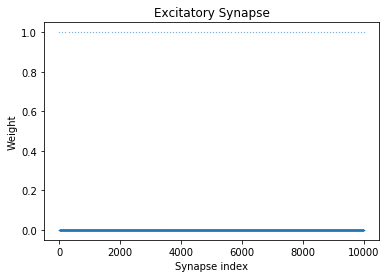

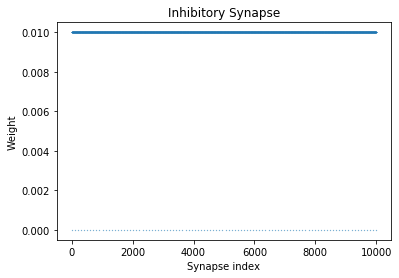

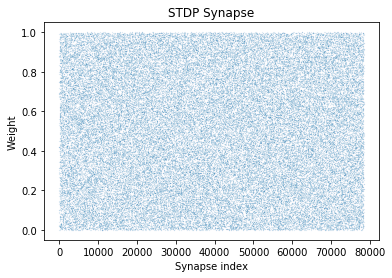

In [6]:
# 最初のSynapseのWeightを表示
b2.plot(connections['ei'].w,'.',markersize = 0.5)
b2.xlabel('Synapse index')
b2.ylabel('Weight')
b2.title("Excitatory Synapse");
b2.show()
b2.plot(connections['ie'].w,'.',markersize = 0.5)
b2.xlabel('Synapse index')
b2.ylabel('Weight')
b2.title("Inhibitory Synapse");
b2.show()
b2.plot(connections['Xe'].w,'.',markersize = 0.1)
b2.xlabel('Synapse index')
b2.ylabel('Weight')
b2.title("STDP Synapse");
b2.show()

In [7]:
# run the simulation（plotはSpikeファルダとSynapseフォルダに保存）
t_start = 0
b2.figure(figsize=(16.0, 12.0))
for j in range(num_examples):
    # signal input
    spike_rates = x_all[j,:] * input_intensity
    input_groups['X'].rates = spike_rates
    t_end = t_start + 500
    net.run(single_example_time)
    # rest input
    input_groups['X'].rates = 0 * b2.Hz
    net.run(resting_time)
    # plot
    b2.subplot(3,1,1)
    b2.plot(spike_monitors['X'].t/b2.ms, spike_monitors['X'].i, '.')
    b2.xlim([t_start, t_end])
    b2.ylabel("Input_layer")
    b2.title("Spike_%05d" % j)
    b2.subplot(3,1,2)
    b2.plot(spike_monitors['e'].t/b2.ms, spike_monitors['e'].i, '.')
    b2.xlim([t_start, t_end])
    b2.ylabel("Exc_layer")
    b2.subplot(3,1,3)
    b2.plot(spike_monitors['i'].t/b2.ms, spike_monitors['i'].i, '.')
    b2.xlim([t_start, t_end])
    b2.ylabel("Inh_layer")
    b2.savefig("Spike/raster_%05d.jpeg" % j)
    b2.clf()
    b2.plot(connections['Xe'].w,'.',markersize = 0.1)
    b2.xlabel('Synapse index')
    b2.ylabel('Weight')
    b2.title("Synapse_%05d" % j);
    b2.savefig("Synapse/weight_%05d.jpeg" % j)
    b2.clf()
    t_start = t_end
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<Figure size 1152x864 with 0 Axes>

In [8]:
# Weightのセーブ
STDP_Weight = connections['Xe'].w
np.save('training_weight.npy',STDP_Weight.get_item(range(STDP_Weight.shape[0])))

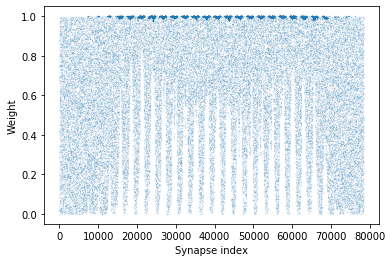

In [9]:
# 最終的なSynapseのWeight
b2.plot(connections['Xe'].w,'.',markersize = 0.1)
b2.xlabel('Synapse index')
b2.ylabel('Weight');
b2.show()

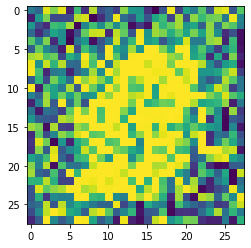

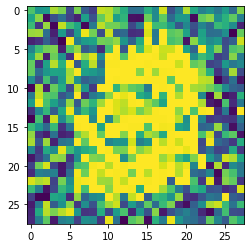

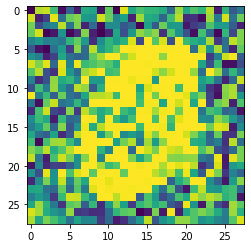

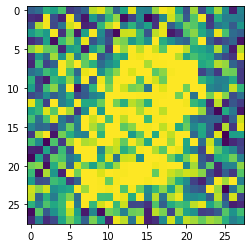

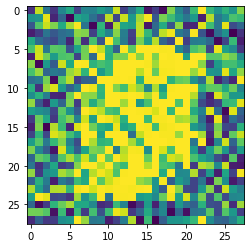

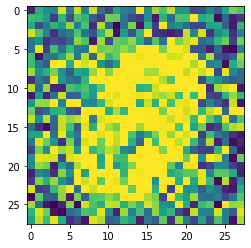

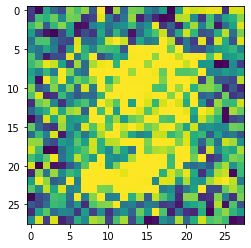

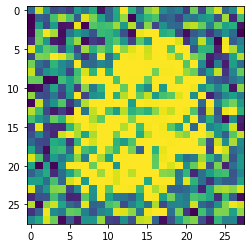

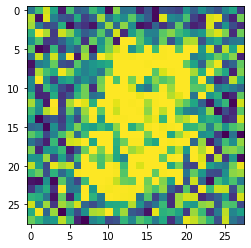

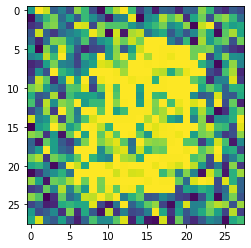

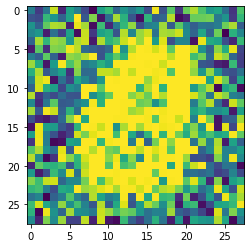

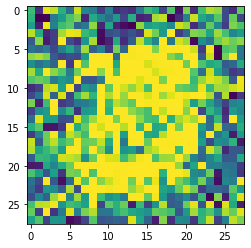

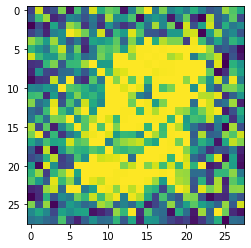

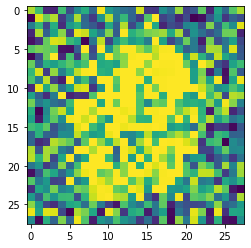

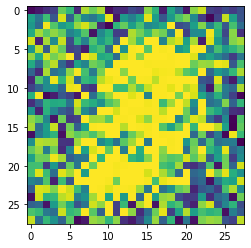

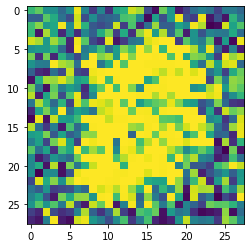

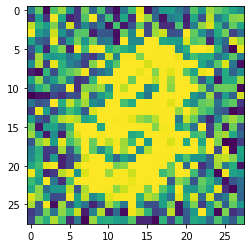

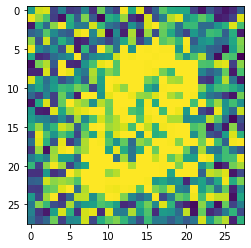

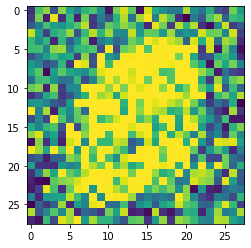

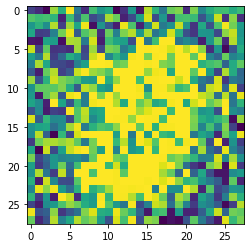

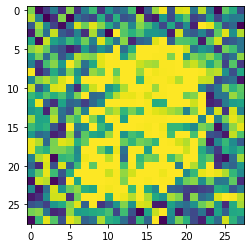

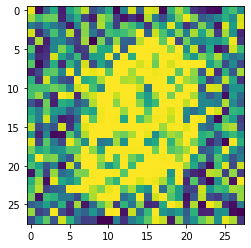

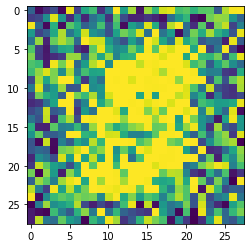

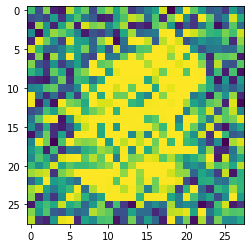

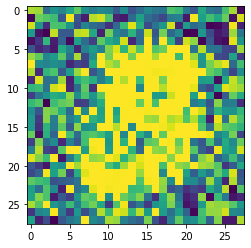

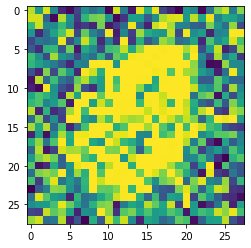

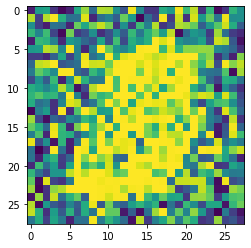

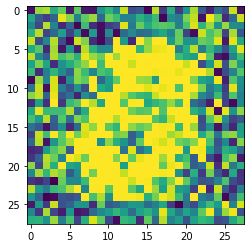

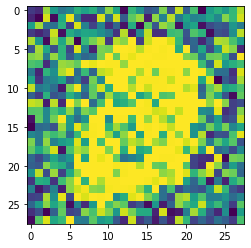

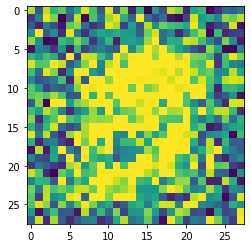

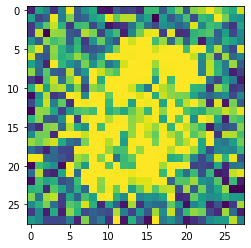

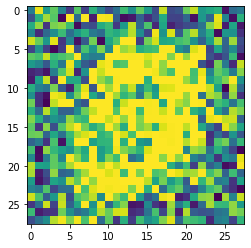

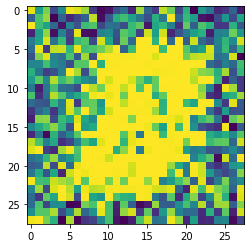

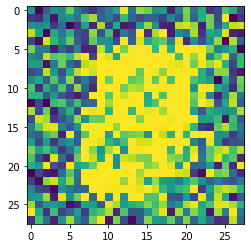

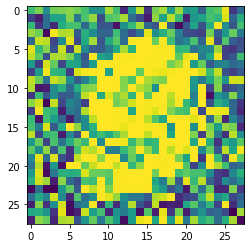

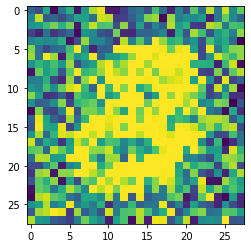

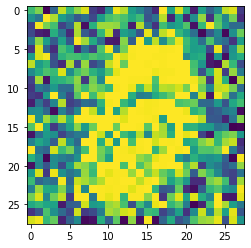

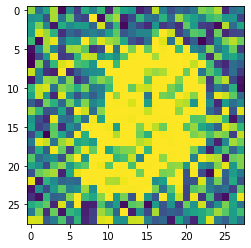

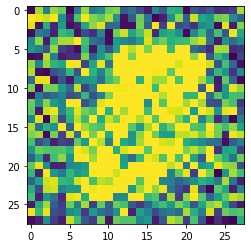

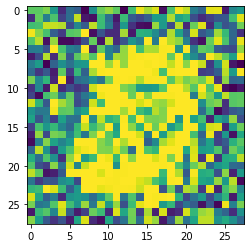

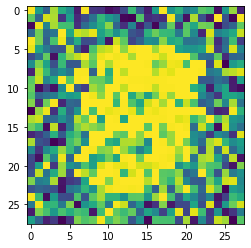

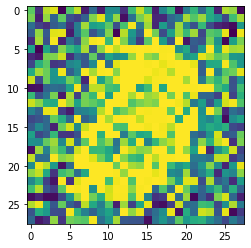

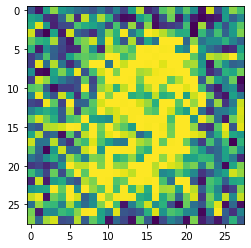

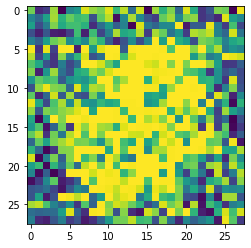

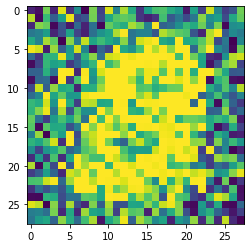

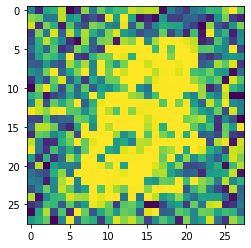

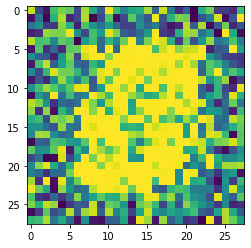

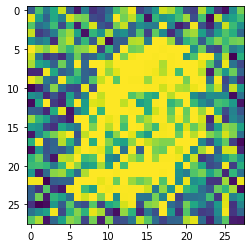

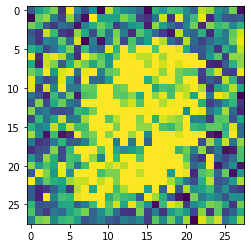

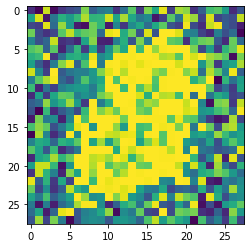

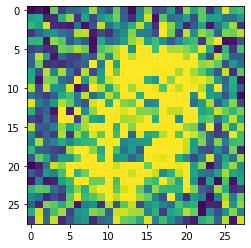

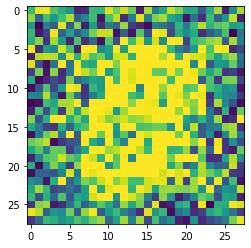

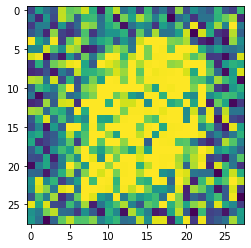

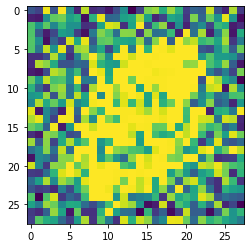

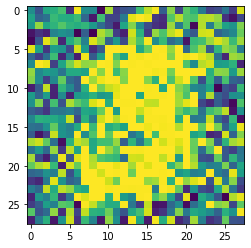

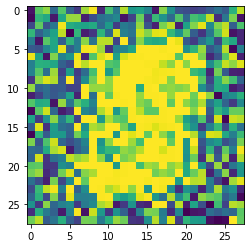

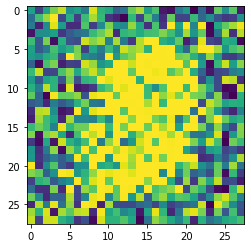

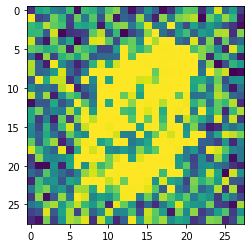

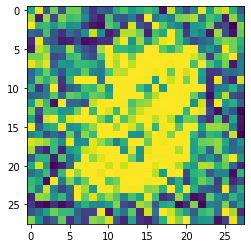

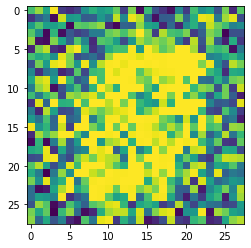

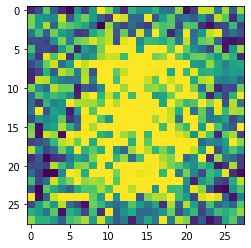

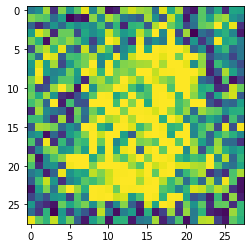

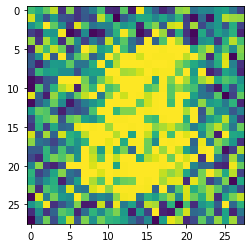

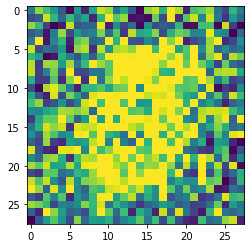

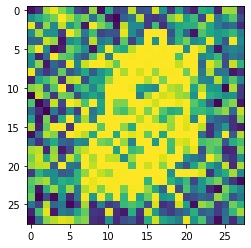

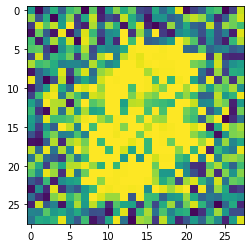

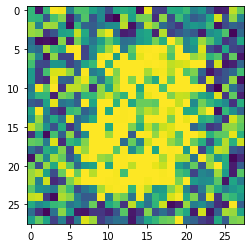

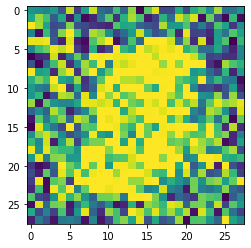

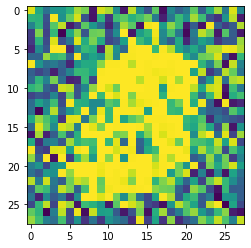

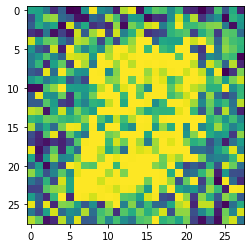

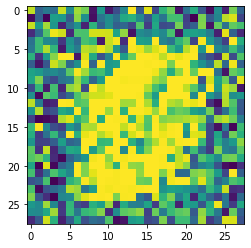

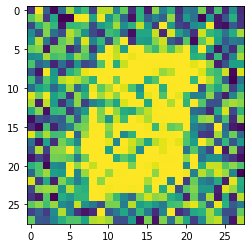

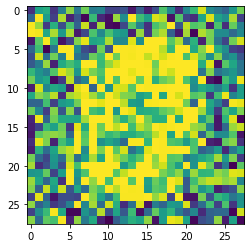

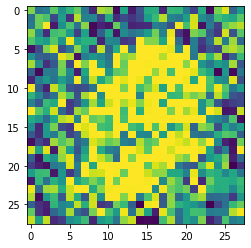

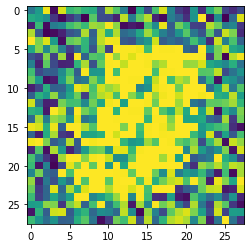

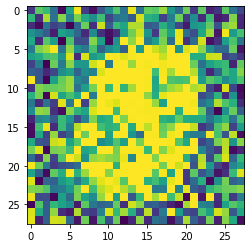

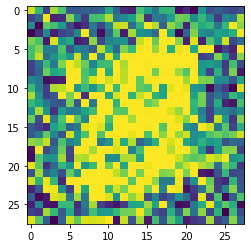

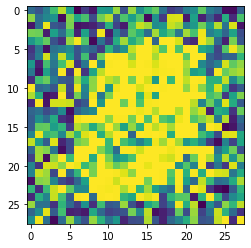

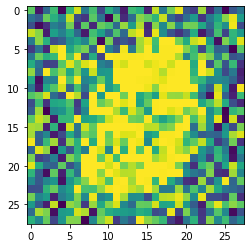

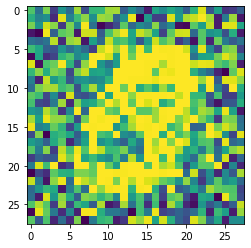

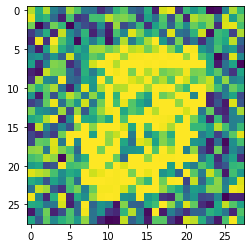

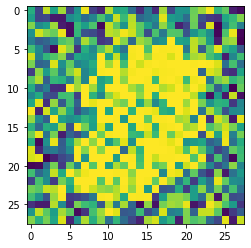

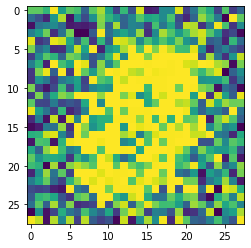

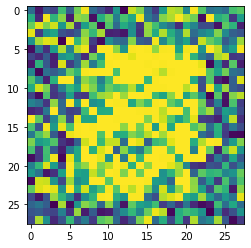

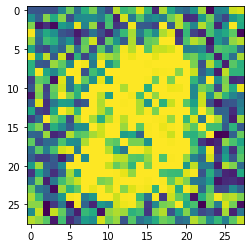

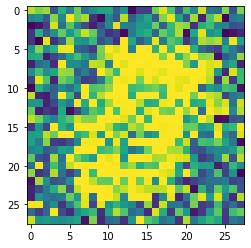

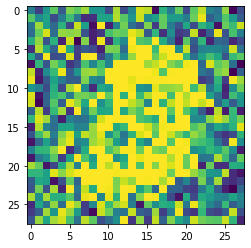

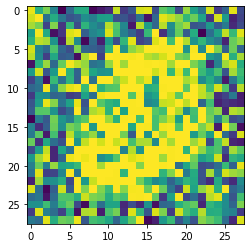

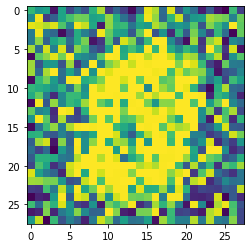

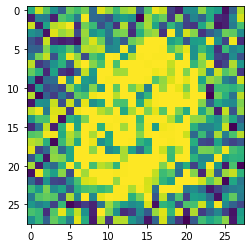

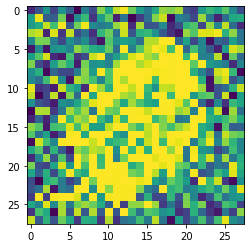

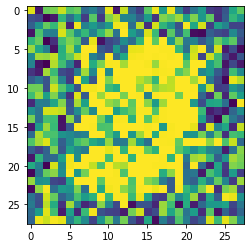

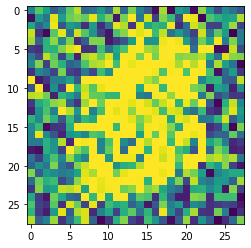

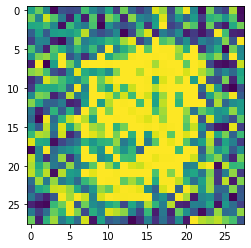

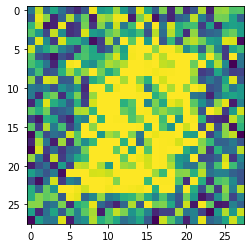

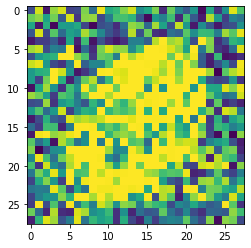

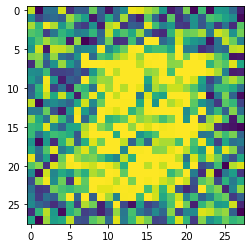

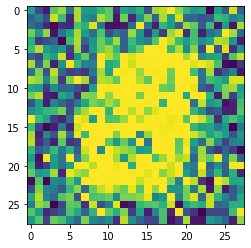

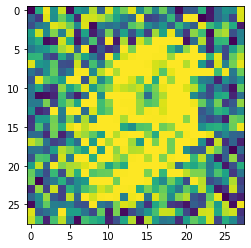

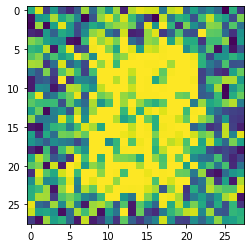

In [10]:
# Weight Mapの可視化
W = STDP_Weight.get_item(range(STDP_Weight.shape[0])).reshape([n_input, n_e])
for i in range(n_e):
    b2.imshow(W[:,i].reshape(28, 28))
    b2.show()